In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overriding 

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '06_04_24_WMH_DifferenceExps'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 106272 -> 106260 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                       log_set                                              
/storage/vbutoi/scratch/ESE/inference/06_04_24_WMH_DifferenceExps/WMH_Individual_LTS           20240604_141554-8VJJ-7bebd0877dde85cf087974947675ece0    9593
                                                                                               20240604_141559-4UXT-77d2072589eb49ed7970f66916e1dcbf    9593
                                                                                               20240604_141604-N2LU-68d78b3437cbb1f1150dd63dc561232c    9593
                                                                                               20240604_141606-WYRR-e76508b56ce20ba295e76beea64503c5    9593
/storage/vbutoi/scratch/ESE/inference/06_04_24_WMH_DifferenceExps/WMH_Individual_T

In [4]:
# We are limiting ourselves to looking at the calibration split for now.
inference_df = inference_df.select(split='cal')

In [5]:
# We want to compare how Dice relates to ECE, this means we need to pivot our dataframe
inference_df_piv = inference_df.pivot(
    index=[
        "calibrator", 
        "dataset_name", 
        "exp_name", 
        "data_id",
        "joint_data_slice_id",
        "pred_hash",
        "pretrained_exp_root", 
        "split", 
    ], 
    columns='image_metric', 
    values='metric_score'
).reset_index()

In [6]:
inference_df_piv['calibrator'] = inference_df_piv['calibrator'].astype('category')
inference_df_piv['calibrator'] = inference_df_piv['calibrator'].cat.reorder_categories([
    'Uncalibrated',
    'TempScaling',
    'LTS',
])

# inference_df_piv['split'] = inference_df_piv['split'].astype('category')
# inference_df_piv['split'] = inference_df_piv['split'].cat.reorder_categories([
#     'val',
#     'cal'
# ])

In [7]:
# Melt the dataframe
difference_df = pd.melt(
    inference_df_piv, 
    id_vars=[
        'data_id', 
        'calibrator', 
        'pretrained_exp_root', 
        'split', 
        'pred_hash',
    ], 
    value_vars=[
        'SoftVolumeError', 
        'HardVolumeError'
    ], 
    var_name='Pred_Type', 
    value_name='Difference_Measurement_Error'
)

Text(0.5, 1.0, 'Volume Differences Between Predictions')

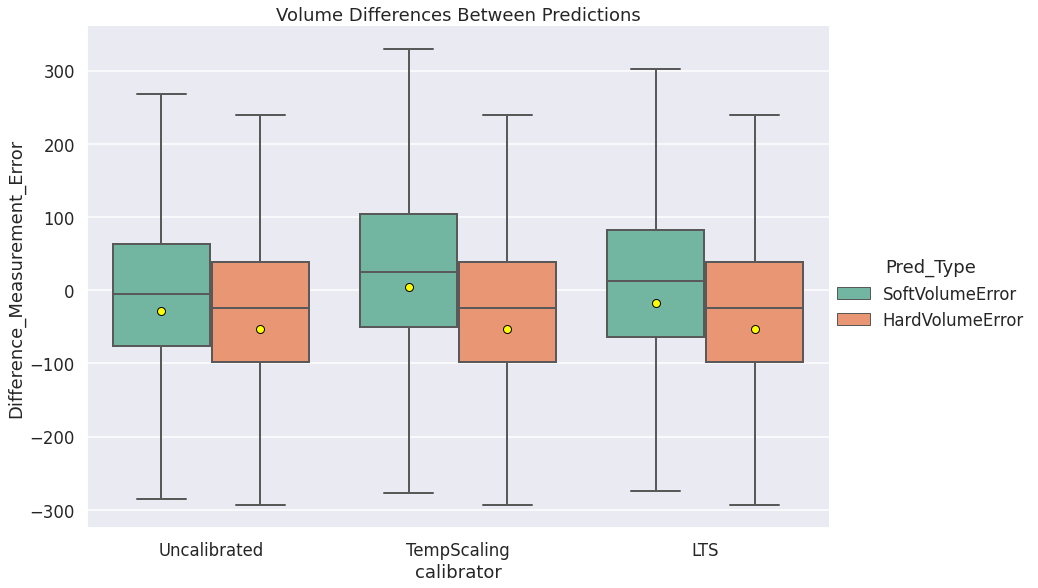

In [8]:
# Create the boxplot
g = sns.catplot(
    x='calibrator',
    y='Difference_Measurement_Error',
    kind='box',
    data=difference_df,
    hue='Pred_Type',
    palette="Set2",       # Use a color palette
    linewidth=2,          # Set the linewidth of the edge
    showfliers=False,     # Do not show outliers
    aspect=1.5,            # Adjust the aspect ratio
    height=8,
    showmeans=True,       # Show the mean
    meanprops={"marker":"o", "markerfacecolor":"yellow", "markeredgecolor":"black", "markersize":"8"}
)
plt.title('Volume Differences Between Predictions')

Text(0.5, 1.0, 'Volume Differences Between Predictions')

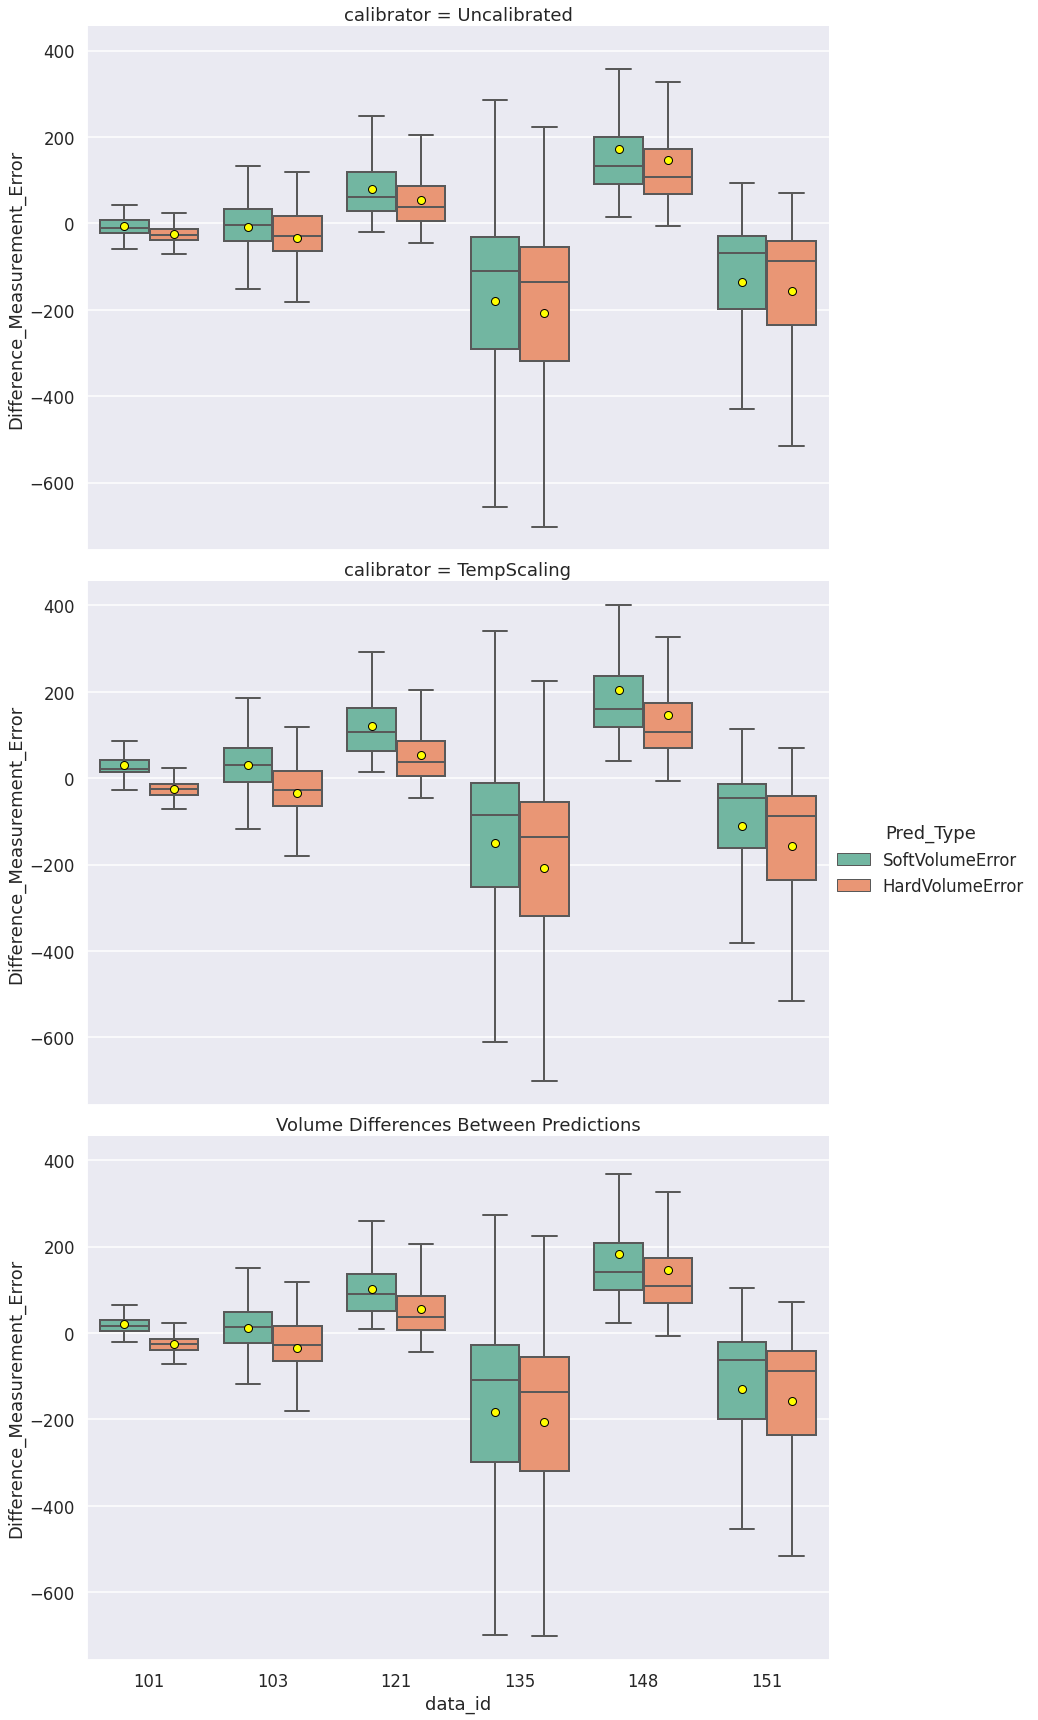

In [9]:
# Create the boxplot
g = sns.catplot(
    x='data_id',
    y='Difference_Measurement_Error',
    row='calibrator',
    hue='Pred_Type',
    kind='box',
    data=difference_df,
    palette="Set2",       # Use a color palette
    linewidth=2,          # Set the linewidth of the edge
    showfliers=False,     # Do not show outliers
    aspect=1.5,            # Adjust the aspect ratio
    height=8,
    showmeans=True,       # Show the mean
    meanprops={"marker":"o", "markerfacecolor":"yellow", "markeredgecolor":"black", "markersize":"8"}
)
plt.title('Volume Differences Between Predictions')

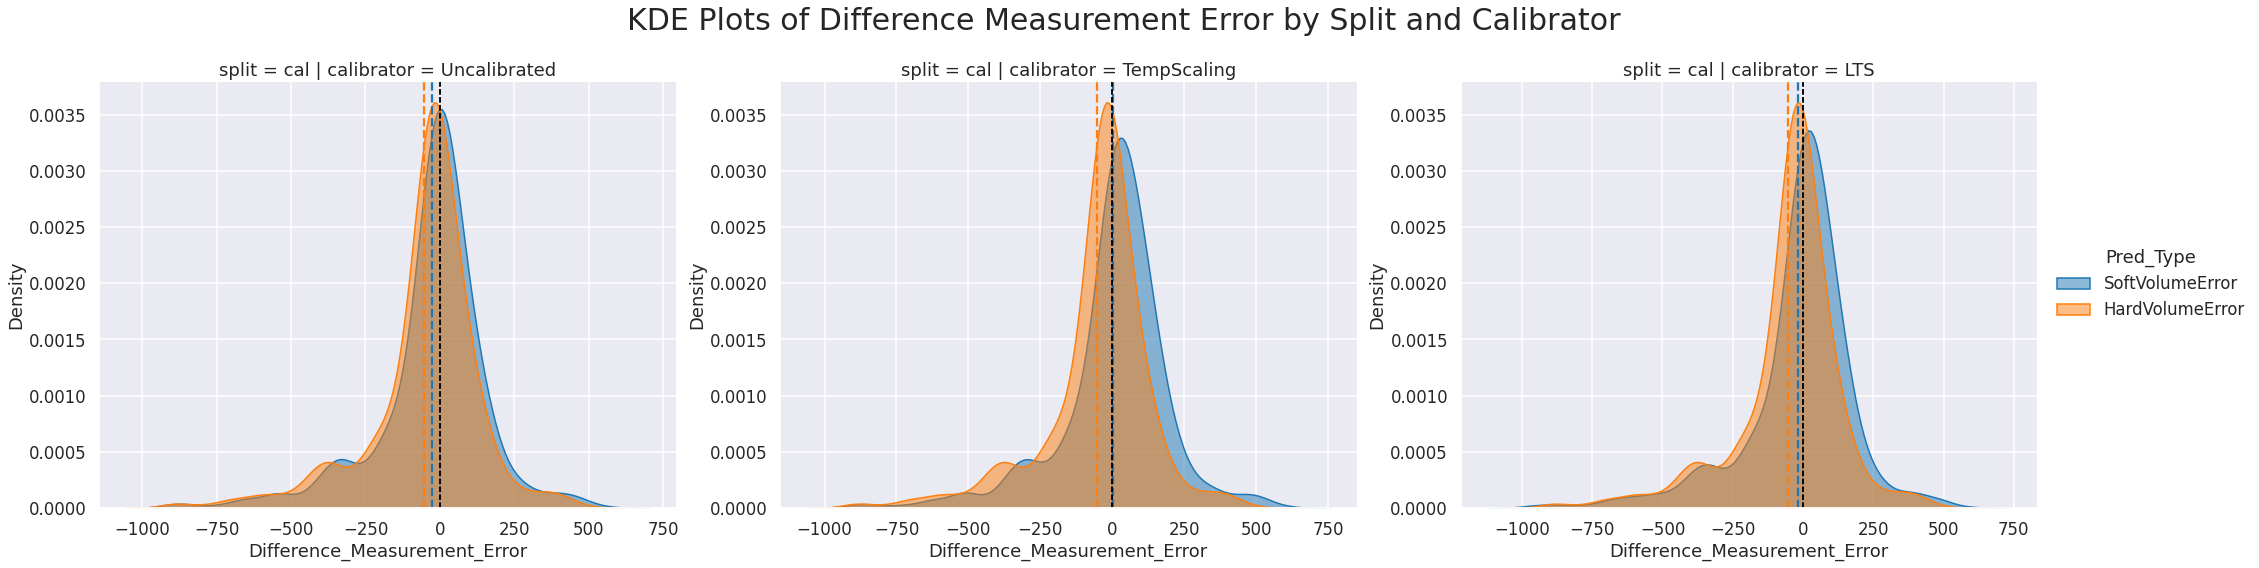

In [10]:
import numpy as np

# Create a FacetGrid with dataset_name as columns
g = sns.FacetGrid(
    difference_df, 
    col='calibrator', 
    row='split',
    hue='Pred_Type', 
    height=8, 
    aspect=1.2, 
    sharex=False, 
    sharey=False
)

def kde_with_mean(data, **kwargs):
    sns.kdeplot(data, fill=True, alpha=0.5, **kwargs)
    mean_val = np.mean(data)
    plt.axvline(mean_val, linestyle='--', color=kwargs.get('color', 'k'))
    plt.axvline(0, linestyle='--', color='black', linewidth=1.5)

# Map the KDE plot to the grid
g.map(kde_with_mean, 'Difference_Measurement_Error')

# Add a legend
g.add_legend()

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('KDE Plots of Difference Measurement Error by Split and Calibrator', fontsize=30)

# Show the plot
plt.show()